In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all confernece wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

In [2]:
# Compare the conferences of two teams playing in a game.
# If both teams are in power conference or both teams are not in a power conference return 0.
# If the opponent team is in a power conference and the first team is not in a power conference return -1
# If the first team is a power conference team and opponent is not then return 1.

def conf_compare(team_conf, opp_conf):
    team_top = team_conf in top_tournament_conferences_list
    opp_top = opp_conf in top_tournament_conferences_list
    if team_top == opp_top:
        return 0
    elif team_top :
        return 1
    else:
        return -1

In [3]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [4]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [5]:
def get_tournament_record(df, season, round_, team):
    return df[(df['season_t'] == season) & (df['round']== round_) & (df['team']==team)]


In [6]:
def print_game_info(df, season, round_, team):
    t_rec = get_tournament_record(df, season, round_, team)
    opp_team = t_rec['opp_team'].iloc[0]
    print('\t\t',team,'\t',opp_team)
    print('Seed','\t\t',"%6d"%t_rec['team_seed'].iloc[0],'\t',"%6d"%t_rec['opp_team_seed'].iloc[0])
    print('PPG','\t\t',"%6.2f"%t_rec['points_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['points_avg_o'].iloc[0])
    print('Allow PPG','\t',"%6.2f"%t_rec['opp_pts_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['opp_pts_avg_o'].iloc[0])
    print('Poss Avg','\t',"%6.2f"%t_rec['possesion_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['possesion_avg_o'].iloc[0])
    print('FG %','\t\t',"%6.2f"%(100*t_rec['fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['fg_pct_o'].iloc[0]))
    print('Allow FG %','\t',"%6.2f"%(100*t_rec['allow_fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['allow_fg_pct_o'].iloc[0]))
    print('Off Rb Avg','\t',"%6.2f"%t_rec['off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rebs_avg_o'].iloc[0])
    print('Allow Off Rb Avg',"%6.2f"%t_rec['allow_off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_off_rebs_avg_o'].iloc[0])
    print('Def Rb Avg','\t',"%6.2f"%t_rec['def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['def_rebs_avg_o'].iloc[0])
    print('Allow Def Rb Avg',"%6.2f"%t_rec['allow_def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_def_rebs_avg_o'].iloc[0])  
    print('FT ATT Avg','\t',"%6.2f"%t_rec['ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['ft_att_avg_o'].iloc[0]) 
    print('Allow FT ATT Avg',"%6.2f"%t_rec['allow_ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_ft_att_avg_o'].iloc[0])
    print('FT %','\t\t',"%6.2f"%(100*t_rec['ft_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['ft_pct_o'].iloc[0]))
    print('Turnover Avg','\t',"%6.2f"%t_rec['turnover_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['turnover_avg_o'].iloc[0])
    print('Takeaway Avg','\t',"%6.2f"%t_rec['take_away_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['take_away_avg_o'].iloc[0])
    print('Win %','\t\t',"%6.2f"%(100*t_rec['win_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['win_pct_o'].iloc[0]))
    print('Off Rating','\t',"%6.2f"%t_rec['off_rating_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rating_o'].iloc[0])
    print('\n\nTop Conference= ', t_rec['top_conf'].iloc[0])
    print('Game Result= ', t_rec['game_result'].iloc[0], ' (One indicates win for ', team,')')
    print('Predicted Result= ', t_rec['predicted_result'].iloc[0])
    print('Predicted Probability= ',"%6.3f"%t_rec['pred_win_prob'].iloc[0])
    return

In [7]:

#Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv('sr_summaries_kaggle_id.csv')
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [8]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2772, 22)


In [9]:
# Read table of team names and associated team meta data
teams = pd.read_csv('D1_teams.csv')
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


In [31]:
tourney_data = pd.read_csv('tournament_results.csv')
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)
tourney_data['train_rec'] = 0
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 10 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
train_rec       2117 non-null int64
dtypes: int64(5), object(5)
memory usage: 165.5+ KB


### Extract some historical data

In [32]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [33]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [34]:
tourney_data.describe()['season']

count    2117.000000
mean     2001.193198
std         9.563883
min      1985.000000
25%      1993.000000
50%      2001.000000
75%      2010.000000
max      2017.000000
Name: season, dtype: float64

Note the tournament data is available for tournament years 1985 through 2017.

In [35]:
summary_data.describe()['season']

count    2772.00000
mean     2012.53355
std         2.28420
min      2009.00000
25%      2011.00000
50%      2013.00000
75%      2015.00000
max      2016.00000
Name: season, dtype: float64

The summary season data is available from 2013 through 2017.

So the intersection of season summary data with tournament data are seasons 2013-2014, 2014-2015, 2015-2016, 2016-2017.

In [36]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [37]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 10 to 2104
Data columns (total 10 columns):
season          533 non-null int64
round           533 non-null int64
game_date       533 non-null object
win_seed        533 non-null int64
win_market      533 non-null object
win_team_id     533 non-null object
lose_seed       533 non-null int64
lose_market     533 non-null object
lose_team_id    533 non-null object
train_rec       533 non-null int64
dtypes: int64(5), object(5)
memory usage: 45.8+ KB


In [38]:

tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id,train_rec
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,0
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,0


In [39]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,0,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,0,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,0,1,2010
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,0,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,0,1,2010
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,0,1,2015


In [40]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010


In [41]:

tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
#tourney_data.info()

In [42]:
#tourney_data.head()

In [43]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [44]:
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


Incorporate additional features here.
Team conference, seeding deltas.

In [45]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [46]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [47]:
print(top_tournament_conferences_list)
tourney_data['top_conf'] = tourney_data.apply(lambda row: conf_compare(row.conf_name_t, row.conf_name_o),axis=1)
tourney_data.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,0,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,0,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,0,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,0,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [48]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_data['upset_seed_threshold'] = tourney_data.apply(lambda row: abs(row.team_seed - row.opp_team_seed) > 6, axis=1).astype(int)
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,1,1


In [49]:
tourney_data['srs_sqr_t'] = tourney_data['SRS_t'] * tourney_data['SRS_t'] 
tourney_data['srs_sqr_o'] = tourney_data['SRS_o'] * tourney_data['SRS_o'] 
tourney_data['off_rating_sqr_t'] = tourney_data['off_rating_t'] * tourney_data['off_rating_t'] 
tourney_data['off_rating_sqr_o'] = tourney_data['off_rating_o'] * tourney_data['off_rating_o'] 

In [50]:
numeric_feature_to_scale = ['pts_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'to_avg_t','steal_avg_t',
                            'SRS_t',
                            'off_rating_t',
                            'pts_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'to_avg_o','steal_avg_o',
                            'SRS_o',
                            'off_rating_o',
                             'srs_sqr_t','srs_sqr_o','off_rating_sqr_t','off_rating_sqr_o']

scaler =StandardScaler()
tourney_data[numeric_feature_to_scale] = scaler.fit_transform(tourney_data[numeric_feature_to_scale])
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,North Carolina State,35,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,Atlantic Coast,American Athletic,1,0,-0.309298,-0.944152,0.564366,-0.512594
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Temple,34,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,American Athletic,Big Ten,-1,0,-0.599033,-0.642088,-0.580318,-0.653018
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Akron,33,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,Mid-American,Atlantic 10,0,1,-1.077425,0.167481,-1.058146,-0.343703
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Virginia Commonwealth,36,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,Atlantic 10,American Athletic,0,1,-1.014051,0.271334,-1.226306,0.783481
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Kansas,38,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,Big 12,Atlantic 10,1,1,1.762790,-1.043280,1.178463,-0.227863


In [51]:
feature_data = tourney_data.drop(columns=['round','game_date','team','team_id_t',
                                         'opp_team','opp_team_id','game_result','start_season',
                                         'season_o','team_id_o','Games_t','Games_o',
                                          'School_o','School_t','SOS_o','SOS_t',
                                         'conf_name_t','conf_name_o','train_rec']).copy()
feature_data.head()

,season_t,team_seed,opp_team_seed,SRS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,SRS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
0,2013,8,9,0.008079,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,-0.598892,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,1,0,-0.309298,-0.944152,0.564366,-0.512594
1,2011,7,10,-0.250945,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,-0.275443,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,-1,0,-0.599033,-0.642088,-0.580318,-0.653018
2,2013,12,5,-0.808437,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,0.370138,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,0,1,-1.077425,0.167481,-1.058146,-0.343703
3,2012,12,5,-0.719028,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,0.439824,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,0,1,-1.014051,0.271334,-1.226306,0.783481
4,2011,1,11,1.293993,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,-0.725115,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,1,1,1.762790,-1.043280,1.178463,-0.227863


In [56]:
feature_data_diff = feature_data.copy()
feature_data_diff['margin_victory_t'] = feature_data_diff['pts_avg_t'] - feature_data_diff['opp_pts_avg_t']
feature_data_diff['margin_victory_o'] = feature_data_diff['pts_avg_o'] - feature_data_diff['opp_pts_avg_o']
feature_data_diff['delta_margin_victory_avg'] = feature_data_diff['margin_victory_t'] - feature_data_diff['margin_victory_o']

#feature_data_diff['delta_points_avg'] = feature_data_diff['pts_avg_t'] - feature_data_diff['pts_avg_o']
#feature_data_diff['opp_pts_avg'] = feature_data_diff['opp_pts_avg_t'] - feature_data_diff['opp_pts_avg_o']


feature_data_diff['fg_pct'] = feature_data_diff['fg_pct_t'] - feature_data_diff['fg_pct_o']
#feature_data_diff['allow_fg_pct'] = feature_data_diff['allow_fg_pct_t'] - feature_data_diff['allow_fg_pct_o']
feature_data_diff['off_rebs_avg'] = feature_data_diff['off_rebs_avg_t'] - feature_data_diff['off_rebs_avg_o']
feature_data_diff['def_rebs_avg'] = feature_data_diff['def_rebs_avg_t'] - feature_data_diff['def_rebs_avg_o']
feature_data_diff['allow_def_rebs_avg'] = feature_data_diff['allow_def_rebs_avg_t'] - feature_data_diff['allow_def_rebs_avg_o']
feature_data_diff['ft_pct'] = feature_data_diff['ft_pct_t'] - feature_data_diff['ft_pct_o']

feature_data_diff['to_net_avg_t'] = feature_data_diff['to_avg_t'] - feature_data_diff['steal_avg_t']
feature_data_diff['to_net_avg_o'] = feature_data_diff['to_avg_o'] - feature_data_diff['steal_avg_o']
feature_data_diff['delta_to_net_avg'] = feature_data_diff['to_net_avg_t'] - feature_data_diff['to_net_avg_o']

#feature_data_diff['turnover_avg'] = feature_data_diff['turnover_avg_t'] - feature_data_diff['turnover_avg_o']
#feature_data_diff['take_away_avg'] = feature_data_diff['take_away_avg_t'] - feature_data_diff['take_away_avg_o']

feature_data_diff['win_pct'] = feature_data_diff['win_pct_t'] - feature_data_diff['win_pct_o']
feature_data_diff['off_rating'] = feature_data_diff['off_rating_t'] - feature_data_diff['off_rating_o']

feature_data_diff['allow_off_rebs_avg'] = feature_data_diff['allow_off_rebs_avg_t'] - feature_data_diff['allow_off_rebs_avg_o']
feature_data_diff['ft_att_avg'] = feature_data_diff['ft_att_avg_t'] - feature_data_diff['ft_att_avg_o']

feature_data_diff['allow_ft_att_avg'] = feature_data_diff['allow_ft_att_avg_t'] - feature_data_diff['allow_ft_att_avg_o']

feature_data_diff['delta_seed'] = feature_data_diff['team_seed'] - feature_data_diff['opp_team_seed']

feature_data_diff.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_t', 'margin_victory_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o'], inplace=True)


In [119]:
feature_data_diff.head()

,team_seed,opp_team_seed,top_conf,delta_points_avg,fg_pct,off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,ft_pct,turnover_avg,take_away_avg,win_pct,off_rating,allow_off_rebs_avg,ft_att_avg,opp_pts_avg,allow_ft_att_avg,delta_seed
0,7,10,1,-1.058716,-0.012572,-1.140235,-0.776340,0.488814,-0.011729,-0.156780,-0.968205,-0.113799,-0.720728,1.404366,0.362110,0.638279,0.435037,-3
1,11,6,0,-1.509179,-0.050458,2.174531,-0.586158,-0.878647,-0.015969,-1.154461,-0.480574,0.008403,-0.259670,-0.771411,1.934959,-1.458361,1.828406,5
2,12,5,-1,1.462215,0.010490,1.237207,-1.483375,-0.294001,0.029042,1.749784,2.658268,0.103416,0.511516,-0.030695,0.477127,1.594678,1.799174,7
3,3,14,1,0.357195,0.051624,-0.879552,0.704920,-2.322210,0.026282,1.150626,-2.518930,0.045887,0.923220,-0.225707,-0.647409,-0.352417,-3.545908,-11
4,4,5,-1,0.032921,-0.021682,0.984856,-0.684352,0.734465,-0.001341,0.972390,0.829966,-0.068627,-0.896575,0.457898,0.581526,1.598027,1.401791,-1


In [57]:
# 
X= feature_data_diff[feature_data_diff['season_t']>=2010]
y= tourney_data[tourney_data['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 23)
(426,)
(107, 23)
(107,)


,team_seed,opp_team_seed,SRS_t,SRS_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o,delta_margin_victory_avg,fg_pct,off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,ft_pct,delta_to_net_avg,win_pct,off_rating,allow_off_rebs_avg,ft_att_avg,allow_ft_att_avg,delta_seed
140,3,14,0.364401,-1.251048,0,1,0.159212,-1.343002,0.338257,-0.707030,0.450177,0.069,-1.142322,-0.941617,-3.621311,-0.008,1.325804,0.081,1.052428,-0.833983,-1.534394,-0.731692,-11
293,5,4,0.140878,0.483214,0,0,-0.144156,0.337619,-0.872689,0.133314,-0.543713,0.000,0.600324,-0.048825,-2.449838,-0.044,1.985520,0.030,-1.024815,-3.015505,-0.055491,-0.370888,1
368,13,4,-1.397485,0.531862,-1,1,-1.367465,0.413417,-0.582434,-1.388465,-0.944750,0.032,-1.689451,0.383237,-0.653651,0.016,1.479134,-0.132,0.846440,-0.099679,-2.676409,0.337941,9
53,3,11,0.551108,-0.696189,1,1,0.437045,-1.021493,-0.199789,0.696904,0.967795,-0.006,3.857777,1.276028,-0.627666,-0.085,-0.239021,0.118,-0.882773,0.656019,1.800716,1.771573,-8
33,3,1,0.860096,1.243186,0,0,0.945695,1.700296,0.969214,1.082798,0.359944,-0.007,-0.569879,-0.034491,-0.653651,0.034,-0.699375,-0.015,-0.105227,-0.812591,-0.422691,-1.079717,2


In [59]:
# mark the records used for training
tourney_data['train_rec'] = 0
tourney_data.loc[X_train.index,'train_rec']= 1

In [60]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[ 0.0570759  -0.01087471  0.94982168 -0.86535912 -0.19662862  0.03658633
   0.95842372 -0.82999536 -0.08560252 -0.13453735 -0.37541113 -0.08301068
   0.06184502 -0.15616818 -0.12438771 -0.08291462 -0.08104567  2.90668572
  -0.17583665  0.04680053 -0.1225347  -0.11362051  0.06795061]]
Intercept  [-0.38452308]


In [61]:
display_important_features_regression(logreg, X_train)

Coefficient Values
win_pct   2.9066857153936394
srs_sqr_t   0.9584237232078144
SRS_t   0.9498216762582914
SRS_o   -0.8653591245435331
srs_sqr_o   -0.8299953636771997
delta_margin_victory_avg   -0.37541113189011055
top_conf   -0.1966286245924983
off_rating   -0.1758366467233249
def_rebs_avg   -0.1561681833129809
off_rating_sqr_o   -0.13453734857078886
allow_def_rebs_avg   -0.12438770727278775
ft_att_avg   -0.12253469654890603
allow_ft_att_avg   -0.11362050545583037
off_rating_sqr_t   -0.08560252166376119
fg_pct   -0.08301068160577081
ft_pct   -0.08291461650051916
delta_to_net_avg   -0.08104566645762876
delta_seed   0.06795060548458702
off_rebs_avg   0.0618450183062579
team_seed   0.05707589607968174
allow_off_rebs_avg   0.04680052804684049
upset_seed_threshold   0.03658633158800168
opp_team_seed   -0.010874709404882306


In [62]:
y_pred = logreg.predict(X_test)
print("LR model prediction accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model prediction accuracy is 0.66


In [63]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.5753101273530524


In [64]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[39, 13],
       [23, 32]], dtype=int64)

Text(0.5,257.44,'Predicted label')

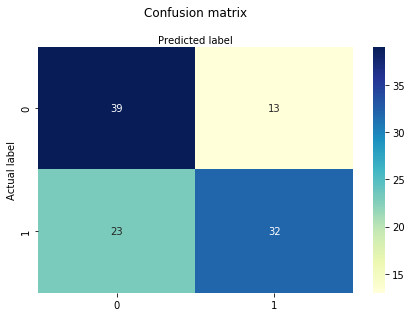

In [65]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [66]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6635514018691588
Precision: 0.7111111111111111
Recall: 0.5818181818181818
Log loss=  0.5753101273530524


In [103]:
# Retrieve the non-normalized game stats
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_data[tourney_data.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,conf_name_t,conf_name_o,top_conf,predicted_result,pred_win_prob
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,76.085714,69.371429,67.893700,0.483704,0.421273,8.171429,8.685714,25.057143,20.457143,20.942857,14.171429,0.724420,11.971429,10.228571,0.742857,112.065942,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,74.454545,71.424242,69.086585,0.432080,0.423374,9.696970,9.000000,23.787879,24.939394,22.787879,25.484848,0.698138,10.424242,14.606061,0.696970,107.769902,Pacific 12,Mountain West,1,1,0.861487
6,2017,32,2017-03-19,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,0,2016,USC,78.222222,73.138889,68.640344,0.455820,0.433794,9.500000,9.750000,23.111111,22.611111,21.861111,14.944444,0.740788,10.861111,12.027778,0.722222,113.959542,Baylor,2016,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,71.852941,63.970588,65.725472,0.466420,0.405561,11.029412,8.558824,22.882353,17.852941,18.823529,16.882353,0.718750,13.000000,10.764706,0.764706,109.322822,Pacific 12,Big 12,0,0,0.297267
28,2014,32,2014-03-22,12,North Dakota State,984e7518-e418-45d5-9797-979b8c2085c1,4,San Diego State,e6914f16-ca37-4d2e-ba26-a425910283e2,0,2013,North Dakota State,73.900000,67.566667,61.735809,0.448276,0.408072,5.250000,9.250000,23.250000,23.500000,19.500000,22.000000,0.756410,9.000000,8.500000,0.766667,119.703623,San Diego State,2013,e6914f16-ca37-4d2e-ba26-a425910283e2,68.205882,58.117647,62.886831,0.419300,0.401551,10.878788,7.906250,21.606061,21.843750,23.969697,16.843750,0.672566,9.060606,12.531250,0.852941,108.458132,Summit League,Mountain West,0,0,0.266246
42,2017,64,2017-03-16,13,East Tennessee State,d750d88f-f7b8-4bc3-a5f6-36e7a67ec93e,4,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,0,2016,East Tennessee State,79.151515,69.727273,72.324275,0.490791,0.416848,8.242424,8.212121,24.484848,21.303030,23.969697,21.272727,0.696587,14.636364,15.363636,0.757576,109.439762,Florida,2016,912f8837-1d81-4ef9-a576-a21f271d4c64,77.888889,66.500000,69.541851,0.449953,0.409749,9.888889,8.861111,23.861111,22.861111,23.638889,19.583333,0.728555,11.583333,14.500000,0.750000,112.002898,Southern,Southeastern,-1,0,0.288146
48,2014,16,2014-03-27,4,UCLA,ec0d6b67-4b16-4b50-92b2-1a651dae6b0f,1,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,0,2013,UCLA,81.162162,70.378378,69.995178,0.488616,0.427009,8.513514,8.486486,24.162162,22.054054,22.675676,20.270270,0.748510,10.189189,14.108108,0.756757,115.953934,Florida,2013,912f8837-1d81-4ef9-a576-a21f271d4c64,69.923077,57.769231,62.876788,0.459630,0.402396,10.102564,8.128205,22.512821,19.512821,22.333333,16.051282,0.668197,10.923077,13.051282,0.923077,111.206502,Pacific 12,Southeastern,0,0,0.304366


In [104]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
missed_predictions[['season_t','round','team','team_seed','conf_name_t', 'opp_team','opp_team_seed', 
                    'conf_name_o','top_conf','predicted_result','game_result','pred_win_prob']]


,season_t,round,team,team_seed,conf_name_t,opp_team,opp_team_seed,conf_name_o,top_conf,predicted_result,game_result,pred_win_prob
224,2017,32,Florida State,3,Atlantic Coast,Xavier,11,Big East,1,1,0,0.816046
140,2015,32,Virginia,2,Atlantic Coast,Michigan State,7,Big Ten,0,1,0,0.802689
260,2017,68,New Orleans,16,Southland,Mount St. Mary's,16,Northeast,0,1,0,0.766418
196,2015,68,North Florida,16,Atlantic Sun,Robert Morris,16,Northeast,0,1,0,0.744945
160,2014,32,Wichita State,1,American Athletic,Kentucky,8,Southeastern,-1,1,0,0.652413
56,2016,64,Pittsburgh,10,Atlantic Coast,Wisconsin,7,Big Ten,0,1,0,0.641291
200,2017,32,Duke,2,Atlantic Coast,South Carolina,7,Southeastern,0,1,0,0.629423
262,2016,32,Stephen F. Austin,14,Southland,Notre Dame,6,Atlantic Coast,-1,1,0,0.584325
60,2014,8,Arizona,1,Pacific 12,Wisconsin,2,Big Ten,0,1,0,0.523829
166,2017,32,Wichita State,10,American Athletic,Kentucky,2,Southeastern,-1,1,0,0.504625


In [42]:
print_game_info(test_games, 2015, 16, 'Duke')

		 Duke 	 Utah
Seed 		      1 	      5
PPG 		  79.26 	  70.91
Allow PPG 	  64.15 	  57.35
Poss Avg 	  66.77 	  62.75
FG % 		  50.16 	  47.75
Allow FG % 	  42.17 	  38.42
Off Rb Avg 	  10.23 	   8.06
Allow Off Rb Avg   9.49 	   8.03
Def Rb Avg 	  24.23 	  23.76
Allow Def Rb Avg  19.51 	  18.53
FT ATT Avg 	  22.38 	  21.82
Allow FT ATT Avg  14.05 	  17.97
FT % 		  69.87 	  70.49
Turnover Avg 	  10.62 	  11.12
Takeaway Avg 	  12.13 	  11.38
Win % 		  89.74 	  73.53
Off Rating 	 118.71 	 113.01


Top Conference=  0
Game Result=  1  (One indicates win for  Duke )
Predicted Result=  0
Predicted Probability=   0.469


In [105]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

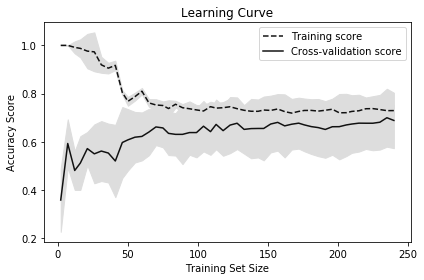

In [106]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Cross Validation Evaluation

In [107]:
scores = cross_val_score(LogisticRegression(), X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.6887362637362637


### Recursive Feature Elimination

In [67]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg,12)
fit = rfe.fit(X,y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 12
Selected Features: [False False  True  True  True False  True  True False  True  True  True
 False False  True  True  True  True False False False False False]
Feature Ranking: [ 9 10  1  1  1  3  1  1  8  1  1  1 12  4  1  1  1  1  2 11  7  5  6]


In [69]:
X_train.iloc[:,fit.support_].head()

,SRS_t,SRS_o,top_conf,srs_sqr_t,srs_sqr_o,off_rating_sqr_o,delta_margin_victory_avg,fg_pct,allow_def_rebs_avg,ft_pct,delta_to_net_avg,win_pct
140,0.364401,-1.251048,0,0.159212,-1.343002,-0.707030,0.450177,0.069,-3.621311,-0.008,1.325804,0.081
293,0.140878,0.483214,0,-0.144156,0.337619,0.133314,-0.543713,0.000,-2.449838,-0.044,1.985520,0.030
368,-1.397485,0.531862,-1,-1.367465,0.413417,-1.388465,-0.944750,0.032,-0.653651,0.016,1.479134,-0.132
53,0.551108,-0.696189,1,0.437045,-1.021493,0.696904,0.967795,-0.006,-0.627666,-0.085,-0.239021,0.118
33,0.860096,1.243186,0,0.945695,1.700296,1.082798,0.359944,-0.007,-0.653651,0.034,-0.699375,-0.015
